<a href="https://colab.research.google.com/github/ebrahimpichka/deep-forecast/blob/main/LSTM_stock_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# restart runtime after running this cell
!pip install -U pandas
!pip install -U pandas_datareader
!pip install -U scikit-learn

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import pandas_datareader.data as web
from datetime import datetime
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import time

plt.style.use("ggplot")

In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
import tensorflow as tf

In [4]:
def calc_ema(df,window,on):
    ema = df[on].ewm(span=window, adjust=False).mean()
    return(ema)

def calc_rsi(df,period=14):
    change = df['Close'].diff(1)
    gain = change.mask(change>0,other=0)
    loss = change.mask(change<0,other=0)
    avg_gain = gain.ewm(span = period).mean()
    avg_loss = loss.ewm(span = period).mean()
    rs = abs(avg_gain/avg_loss)
    rsi = (100/(1+rs))
    return(rsi)

In [5]:
SEED = 42
import os
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
# tf.kera


In [7]:
df = web.DataReader("IBM", data_source='yahoo', start=datetime(2015,1,1), end=datetime(2021,10,10),)
df['EMA16'] = calc_ema(df,16,'Adj Close')
df['RSI14'] = calc_rsi(df,period=14)
# FullData=df[['Adj Close','EMA16','RSI14']].dropna().values
FullData = df[['Adj Close','Volume']].dropna().values
 

In [9]:
# constants
TimeSteps = 16 # next few days Price Prediction is based on last how many past week's prices
FutureTimeSteps =1 # How many day in future you want to predict the prices

# Choosing the number of testing data records
TestSize = 0.2
EPOCHS = 200
TRAIN_MODE = True

In [10]:

# Feature Scaling for fast training of neural networks
sc = MinMaxScaler()
DataScaler = sc.fit(FullData)
X = DataScaler.transform(FullData)
# X=X.reshape(X.shape[0],)

#Multi step data preparation
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i,:]
    y_sample = X[i+FutureTimeSteps-1,0]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
    
 
#Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
# X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

TestingRecords = int(TestSize*X_data.shape[0])
# Splitting the data into train and test
X_train_lstm = X_data[:-TestingRecords]
X_test_lstm = X_data[-TestingRecords:]
y_train_lstm = y_data[:-TestingRecords]
y_test_lstm = y_data[-TestingRecords:]
 
#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train_lstm.shape)
print(y_train_lstm.shape)
 
print('\n#### Testing Data shape ####')
print(X_test_lstm.shape)
print(y_test_lstm.shape)
# Defining Input shapes for LSTM
TimeSteps=X_train_lstm.shape[1]
TotalFeatures=X_train_lstm.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)



### Input Data Shape ###
(1688, 16, 2)
### Output Data Shape ###
(1688,)

#### Training Data shape ####
(1351, 16, 2)
(1351,)

#### Testing Data shape ####
(337, 16, 2)
(337,)
Number of TimeSteps: 16
Number of Features: 2


# LSTM model setting

In [11]:
# Initialising the RNN
lstm_model = tf.keras.Sequential()
# Adding the First input hidden layer and the LSTM layer
lstm_model.add(layers.LSTM(256, activation='relu', input_shape = (TimeSteps, TotalFeatures)))
lstm_model.add(layers.Dense(1))
# Compiling the RNN
lstm_model.compile(optimizer='adam',loss='mse')
###################################################################

if TRAIN_MODE:
    # Measuring the time taken by the model to train
    StartTime=time.time()
    # Fitting the RNN to the Training set
    history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs = EPOCHS, validation_data=(X_test_lstm,y_test_lstm),shuffle=True,batch_size=TestingRecords)
    EndTime=time.time()
    print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')
    lstm_model.save_weights('lstm_predictor_weights.h5')
else:
    lstm_model.load_weights('lstm_predictor_weights.h5')

Epoch 1/200
5/5 [==============================] - 4s 329ms/step - loss: 0.2824 - val_loss: 0.1721
Epoch 2/200
5/5 [==============================] - 1s 243ms/step - loss: 0.0723 - val_loss: 0.0717
Epoch 3/200
5/5 [==============================] - 1s 246ms/step - loss: 0.0459 - val_loss: 0.0114
Epoch 4/200
5/5 [==============================] - 1s 263ms/step - loss: 0.0192 - val_loss: 0.0397
Epoch 5/200
5/5 [==============================] - 1s 241ms/step - loss: 0.0241 - val_loss: 0.0142
Epoch 6/200
5/5 [==============================] - 1s 236ms/step - loss: 0.0077 - val_loss: 0.0077
Epoch 7/200
5/5 [==============================] - 1s 236ms/step - loss: 0.0108 - val_loss: 0.0057
Epoch 8/200
5/5 [==============================] - 1s 231ms/step - loss: 0.0064 - val_loss: 0.0103
Epoch 9/200
5/5 [==============================] - 1s 242ms/step - loss: 0.0079 - val_loss: 0.0071
Epoch 10/200
5/5 [==============================] - 1s 299ms/step - loss: 0.0058 - val_loss: 0.0046
Epoch 11/

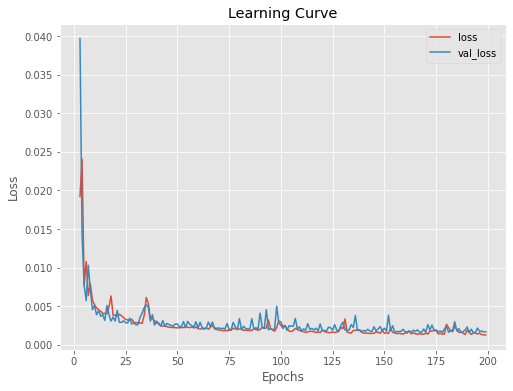

In [12]:
plt.figure(figsize=(8,6))
plt.plot(list(range(3,EPOCHS)), history.history['loss'][3:EPOCHS],label='loss')
plt.plot(list(range(3,EPOCHS)), history.history['val_loss'][3:EPOCHS],label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()

In [14]:
predicted_P = (lstm_model.predict(X_test_lstm) - DataScaler.min_[0])/DataScaler.scale_[0]

orig = y_test_lstm
orig = (orig - DataScaler.min_[0])/DataScaler.scale_[0]

MAE = mean_absolute_error(predicted_P.reshape(-1),orig)
MAPE = mean_absolute_percentage_error(predicted_P.reshape(-1),orig)

print("Mean Absolute Error: {:.2f}\nMean Absolute Percentage Error: %{:.2f}".format(MAE,MAPE*100))

11/11 [==============================] - 0s 25ms/step
Mean Absolute Error: 1.70
Mean Absolute Percentage Error: %1.51


In [15]:
correction = df['Adj Close'][-(TestingRecords + 3):].diff(1).rolling(3).mean().dropna().values

corrected_pred = predicted_P + correction.reshape(-1,1)
corrected_pred.shape

(337, 1)

In [16]:
cMAE = mean_absolute_error(corrected_pred.reshape(-1),orig)
cMAPE = mean_absolute_percentage_error(corrected_pred.reshape(-1),orig)

print("Corrected Mean Absolute Error: {:.2f}\nCorrected Mean Absolute Percentage Error: %{:.2f}".format(cMAE,cMAPE*100))

Corrected Mean Absolute Error: 1.38
Corrected Mean Absolute Percentage Error: %1.22


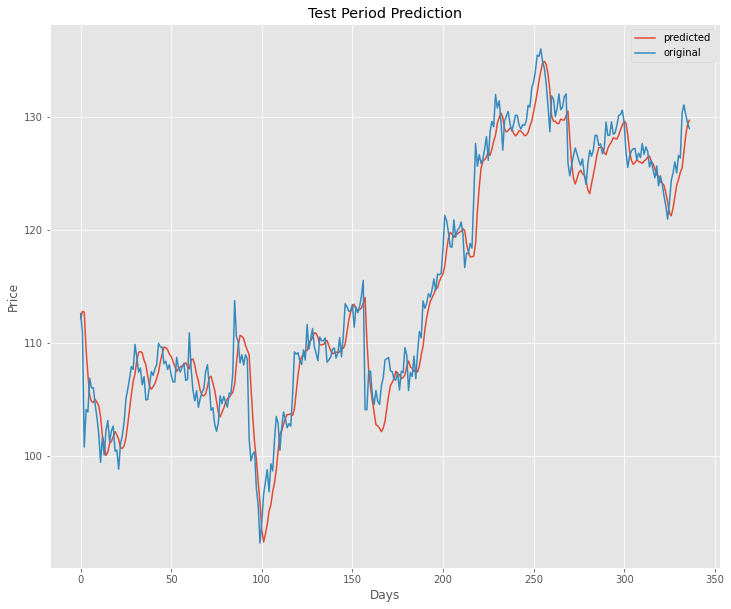

In [17]:
plt.figure(figsize=(12,10))
plt.plot(predicted_P[:,0],label='predicted')
plt.plot(orig,label='original')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Test Period Prediction")
plt.legend()

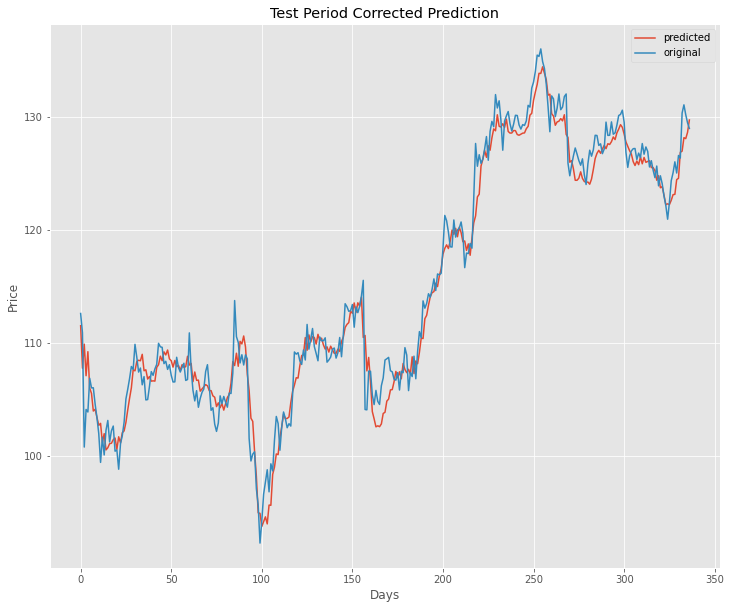

In [18]:
plt.figure(figsize=(12,10))
plt.plot(corrected_pred[:,0],label='predicted')
plt.plot(orig,label='original')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Test Period Corrected Prediction")
plt.legend()

In [33]:
# Generating trading signals
def backtest_lstm(model, time_series, correct=True, correction_window=3, correction_period=2):
    X = time_series.iloc[correction_window+correction_period-1:,:].values
    X = DataScaler.transform(X)
    correction_values = time_series['Adj Close'].diff(correction_period).rolling(correction_window).mean().dropna()
    date = time_series.iloc[correction_window+correction_period-1:,:].index
    prices = time_series.iloc[correction_window+correction_period-1:,:]['Adj Close']

    X_samples = list()
    date_list = list()
    price_list = list()
    diff_list = list()
    prediction_list = list()
    correction_list = list()
    
    NumerOfRows = len(X)
    # predicrions
    for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , FutureTimeSteps):

        x_sample = X[i-TimeSteps:i,:]

        X_samples.append(x_sample)
        date_list.append(date[i-1])
        price_list.append(prices[i-1])
        correction_list.append(correction_values[i-1])
        
        x_sample = np.expand_dims(x_sample, 0)
        pred = ((model.predict(x_sample) - DataScaler.min_[0])/DataScaler.scale_[0]).item()
        prediction_list.append(pred)
        
    X_data=np.array(X_samples)
    
    # backtest
    signal_list = list()
    position = "cash"
    cum_ret = 1
    prev_trades_ret = 1
    return_list = list()
    buy_price = price_list[0]
    trades_return_list = list()

    for index, today_close_price in enumerate(price_list):

        prediction = prediction_list[index]
        
        if correct:
            correction = correction_list[index]
        else:
            correction = 0


        # calulating cumulative return
        if position=="long" :
            cum_ret = prev_trades_ret * (price_list[index]/buy_price)
            # cum_ret *= price_list[index]/buy_price
            return_list.append(cum_ret-1)
        else:
            return_list.append(cum_ret-1)


        # generating signal
        if (prediction+correction > today_close_price) and position=="cash":
            signal_list.append(1)
            position = "long"
            buy_price = price_list[index]

        elif (prediction+correction < today_close_price) and position=="long":
            signal_list.append(-1)
            position = "cash"
            prev_trades_ret = prev_trades_ret * (price_list[index]/buy_price)
            trades_return_list.append((price_list[index]/buy_price)-1)
        else:
            signal_list.append(0)

  
        
    result = pd.DataFrame({
        "price":price_list,
        "prediction":prediction_list,
        "correction":correction_list,
        "strategy_return":return_list,
        "signal":signal_list,
    })

    if not correct:
        result.drop(columns=["correction"],inplace=True)
    result["buy_and_hold_daily_ret"] = result["price"].pct_change().fillna(0)
    result["buy_and_hold_cum_ret"] = (result["buy_and_hold_daily_ret"]+ 1).cumprod() - 1

    result.index = date_list

    return(result, trades_return_list)


In [34]:
time_series = df[['Adj Close','Volume']].dropna().iloc[-TestingRecords:,:]

lstm_normal, lstm_ret_list = backtest_lstm(lstm_model, time_series,correct=False)
lstm_corrected3, lstm_ret_list_cor3 = backtest_lstm(lstm_model, time_series,correct=True, correction_window=3)
lstm_corrected8, lstm_ret_list_cor8 = backtest_lstm(lstm_model, time_series,correct=True, correction_window=8)

1/1 [==============================] - 0s 39ms/step


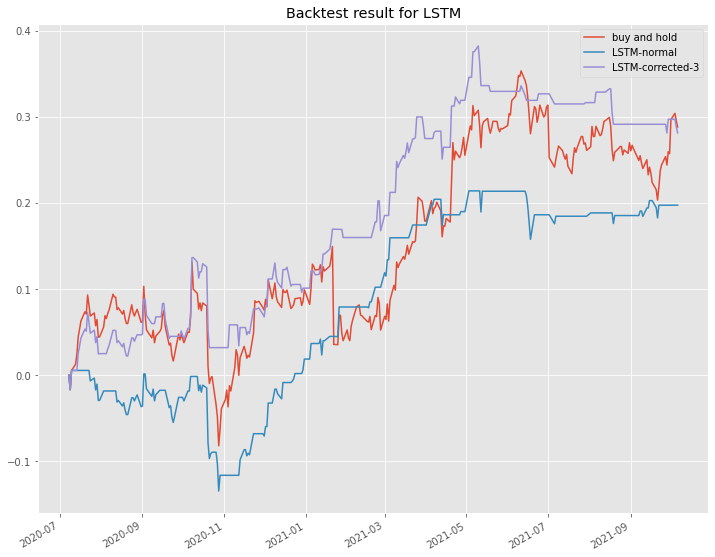

In [35]:
plt.figure(figsize=(12,10))
lstm_normal['buy_and_hold_cum_ret'].plot(label="buy and hold")
lstm_normal['strategy_return'].plot(label="LSTM-normal")
lstm_corrected3['strategy_return'].plot(label="LSTM-corrected-3")
# lstm_corrected8['strategy_return'].plot(label="LSTM-corrected-8")
plt.title("Backtest result for LSTM")
plt.legend()

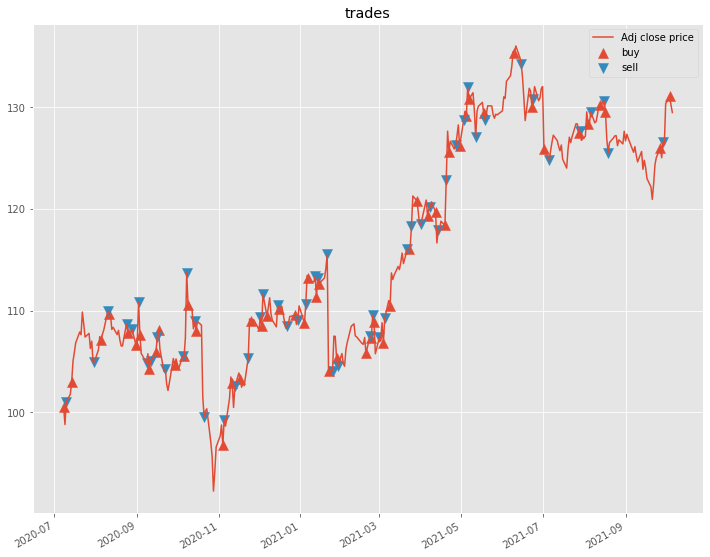

In [36]:
plt.figure(figsize=(12,10))
lstm_corrected3['price'].plot(label="Adj close price")
plt.scatter(lstm_corrected3.index[lstm_corrected3['signal']==1],(lstm_corrected3['signal']*lstm_corrected3['price'])[lstm_corrected3['signal']==1],marker="^", label="buy",s=100)
plt.scatter(lstm_corrected3.index[lstm_corrected3['signal']==-1],(lstm_corrected3['signal']*lstm_corrected3['price'])[lstm_corrected3['signal']==-1].abs(),marker="v", label="sell",s=100)

plt.title("trades")
plt.legend()

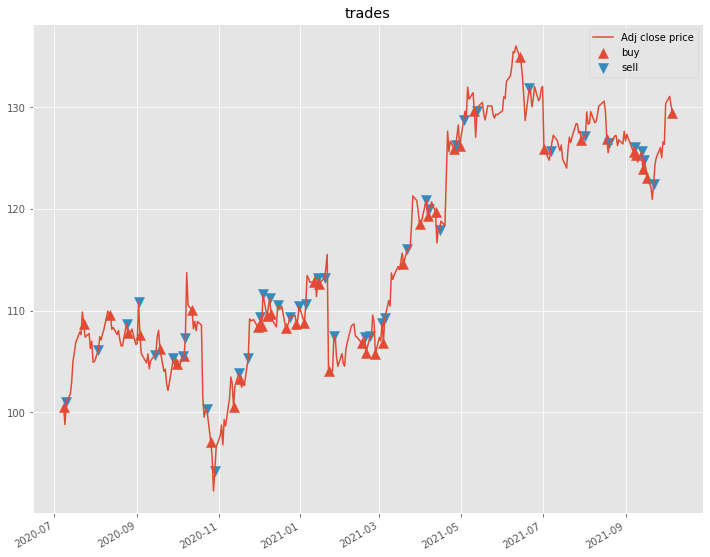

In [37]:
plt.figure(figsize=(12,10))
lstm_normal['price'].plot(label="Adj close price")
plt.scatter(lstm_normal.index[lstm_normal['signal']==1],(lstm_normal['signal']*lstm_normal['price'])[lstm_normal['signal']==1],marker="^", label="buy",s=100)
plt.scatter(lstm_normal.index[lstm_normal['signal']==-1],(lstm_normal['signal']*lstm_normal['price'])[lstm_normal['signal']==-1].abs(),marker="v", label="sell",s=100)

plt.title("trades")
plt.legend()

# MLP


In [26]:
# Feature Scaling for fast training of neural networks
sc_mlp=MinMaxScaler()
 
DataScalerMLP = sc_mlp.fit(FullData)
X=DataScalerMLP.transform(FullData)
# X=X.reshape(X.shape[0],)

#Multi step data preparation
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i,:].reshape(-1)
    y_sample = X[i+FutureTimeSteps-1,0]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
    
 
#Reshape the Input as a 3D (samples, Time Steps, Features)
X_data_mlp=np.array(X_samples)
# X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data_mlp.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data_mlp=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data_mlp.shape)

TestingRecords = int(TestSize*X_data_mlp.shape[0])
# Splitting the data into train and test
X_train_mlp=X_data_mlp[:-TestingRecords]
X_test_mlp=X_data_mlp[-TestingRecords:]
y_train_mlp=y_data_mlp[:-TestingRecords]
y_test_mlp=y_data_mlp[-TestingRecords:]
 
#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train_mlp.shape)
print(y_train_mlp.shape)
 
print('\n#### Testing Data shape ####')
print(X_test_mlp.shape)
print(y_test_mlp.shape)


mlp_features = X_test_mlp.shape[1]

### Input Data Shape ###
(1688, 32)
### Output Data Shape ###
(1688,)

#### Training Data shape ####
(1351, 32)
(1351,)

#### Testing Data shape ####
(337, 32)
(337,)


In [27]:
# Initialising the RNN
mlp_model = tf.keras.Sequential()
# Adding the First input hidden layer and the LSTM layer
mlp_model.add(layers.Dense(256, activation='relu', input_shape = (mlp_features,)))
mlp_model.add(layers.Dense(1))
# Compiling the RNN
mlp_model.compile(optimizer='adam',loss='mse')
###################################################################

if TRAIN_MODE:
    # Measuring the time taken by the model to train
    StartTime=time.time()
    # Fitting the RNN to the Training set
    history = mlp_model.fit(X_train_mlp, y_train_mlp, epochs = EPOCHS, validation_data=(X_test_mlp,y_test_mlp),shuffle=True,batch_size=TestingRecords)
    EndTime=time.time()
    print("############### Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes #############')
    mlp_model.save_weights('mlp_predictor_weights.h5')
else:
    mlp_model.load_weights('mlp_predictor_weights.h5')

Epoch 1/200
5/5 [==============================] - 1s 46ms/step - loss: 0.3386 - val_loss: 0.0247
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0251 - val_loss: 0.0850
Epoch 3/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0781 - val_loss: 0.0426
Epoch 4/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0246 - val_loss: 0.0080
Epoch 5/200
5/5 [==============================] - 0s 12ms/step - loss: 0.0131 - val_loss: 0.0283
Epoch 6/200
5/5 [==============================] - 0s 13ms/step - loss: 0.0215 - val_loss: 0.0170
Epoch 7/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0102 - val_loss: 0.0047
Epoch 8/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0065 - val_loss: 0.0047
Epoch 9/200
5/5 [==============================] - 0s 11ms/step - loss: 0.0060 - val_loss: 0.0041
Epoch 10/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 11/200
5/5 [=

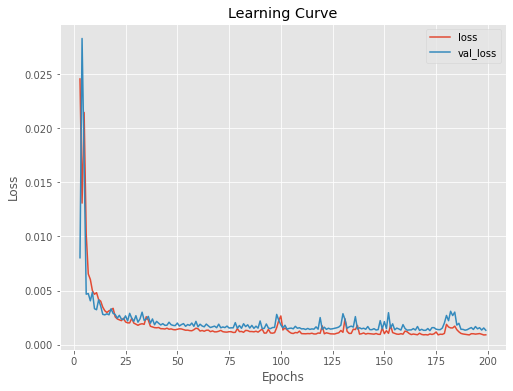

In [28]:
plt.figure(figsize=(8,6))
plt.plot(list(range(3,EPOCHS)), history.history['loss'][3:EPOCHS],label='loss')
plt.plot(list(range(3,EPOCHS)), history.history['val_loss'][3:EPOCHS],label='val_loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend()

In [29]:
predicted_P = (mlp_model.predict(X_test_mlp) - DataScalerMLP.min_[0])/DataScalerMLP.scale_[0]

orig=y_test_mlp
orig= (orig - DataScalerMLP.min_[0])/DataScalerMLP.scale_[0]

MAE = mean_absolute_error(predicted_P.reshape(-1),orig)
MAPE = mean_absolute_percentage_error(predicted_P.reshape(-1),orig)

print("Mean Absolute Error: {:.2f}\nMean Absolute Percentage Error: %{:.2f}".format(MAE,MAPE*100))

11/11 [==============================] - 0s 2ms/step
Mean Absolute Error: 1.45
Mean Absolute Percentage Error: %1.29


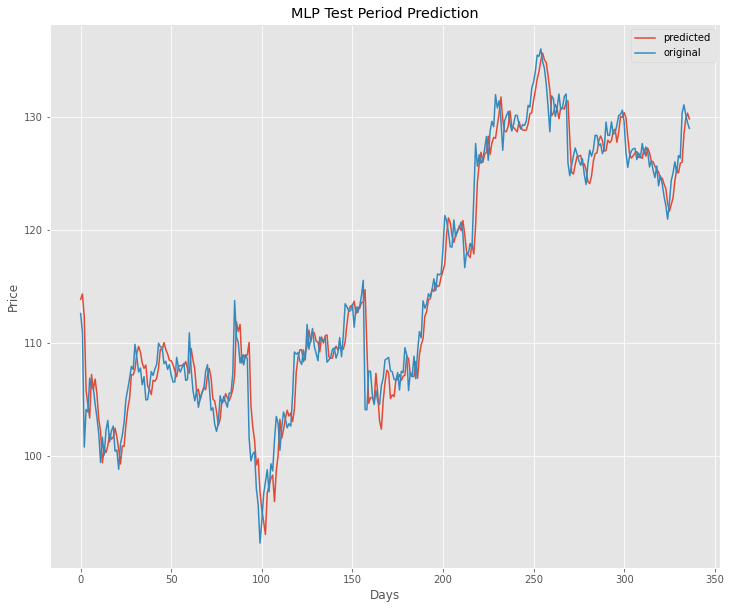

In [30]:
plt.figure(figsize=(12,10))
plt.plot(predicted_P[:,0],label='predicted')
plt.plot(orig,label='original')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("MLP Test Period Prediction")
plt.legend()

In [31]:
correction = df['Adj Close'][-(TestingRecords + 4):].diff(2).rolling(3).mean().dropna().values

corrected_pred = predicted_P + correction.reshape(-1,1)

cMAE = mean_absolute_error(corrected_pred.reshape(-1),orig)
cMAPE = mean_absolute_percentage_error(corrected_pred.reshape(-1),orig)

print("Corrected Mean Absolute Error: {:.2f}\nCorrected Mean Absolute Percentage Error: %{:.2f}".format(cMAE,cMAPE*100))

Corrected Mean Absolute Error: 0.86
Corrected Mean Absolute Percentage Error: %0.76


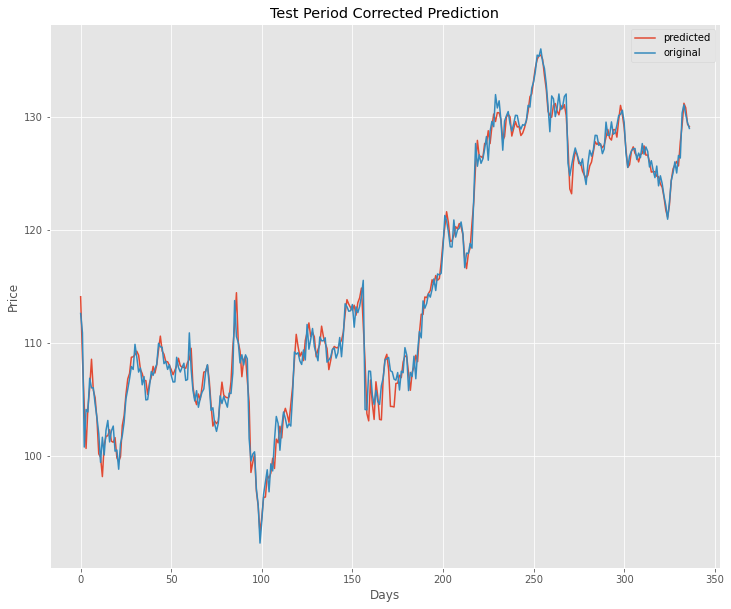

In [32]:
plt.figure(figsize=(12,10))
plt.plot(corrected_pred[:,0],label='predicted')
plt.plot(orig,label='original')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Test Period Corrected Prediction")
plt.legend()

## backtest mlp

In [40]:
# Generating trading signals
def backtest_mlp(model, time_series, correct=False, correction_window=3, correction_period=2):
    X = time_series.iloc[correction_window+correction_period-1:,:].values
    X = DataScaler.transform(X)
    correction_values = time_series['Adj Close'].diff(correction_period).rolling(correction_window).mean().dropna()
    date = time_series.iloc[correction_window+correction_period-1:,:].index
    prices = time_series.iloc[correction_window+correction_period-1:,:]['Adj Close']

    X_samples = list()
    date_list = list()
    price_list = list()
    diff_list = list()
    prediction_list = list()
    correction_list = list()
    
    NumerOfRows = len(X)
    # predicrions
    for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , FutureTimeSteps):

        x_sample = X[i-TimeSteps:i,:].reshape(-1)

        X_samples.append(x_sample)
        date_list.append(date[i-1])
        price_list.append(prices[i-1])
        correction_list.append(correction_values[i-1])
        
        x_sample = np.expand_dims(x_sample, 0)
        pred = ((model.predict(x_sample) - DataScaler.min_[0])/DataScaler.scale_[0]).item()
        prediction_list.append(pred)
        
    X_data=np.array(X_samples)
    

    
    # backtest
    signal_list = list()
    position = "cash"
    cum_ret = 1
    return_list = list()
    buy_price = price_list[0]
    prev_trades_ret = 1
    trades_return_list = list()

    for index, today_close_price in enumerate(price_list):

        prediction = prediction_list[index]
        
        if correct:
            correction = correction_list[index]
        else:
            correction = 0

        # calulating cumulative return
        if position=="long" :
            cum_ret = prev_trades_ret * (price_list[index]/buy_price)
            # cum_ret *= price_list[index]/buy_price
            return_list.append(cum_ret-1)
        else:
            return_list.append(cum_ret-1)


        # generating signal
        if (prediction+correction > today_close_price) and position=="cash":
            signal_list.append(1)
            position = "long"
            buy_price = price_list[index]

        elif (prediction+correction < today_close_price) and position=="long":
            signal_list.append(-1)
            position = "cash"
            prev_trades_ret = prev_trades_ret * (price_list[index]/buy_price)
            trades_return_list.append((price_list[index]/buy_price)-1)
        else:
            signal_list.append(0)

  
        
    result = pd.DataFrame({
        "price":price_list,
        "prediction":prediction_list,
        "correction":correction_list,
        "strategy_return":return_list,
        "signal":signal_list,
    })

    if not correct:
        result.drop(columns=["correction"],inplace=True)
    result["buy_and_hold_daily_ret"] = result["price"].pct_change().fillna(0)
    result["buy_and_hold_cum_ret"] = (result["buy_and_hold_daily_ret"]+ 1).cumprod() - 1

    result.index = date_list

    return(result, trades_return_list)


In [ ]:
time_series = df[['Adj Close','Volume']].dropna().iloc[-TestingRecords:,:]

mlp_normal, mlp_ret_list = backtest_mlp(mlp_model, time_series,correct=False)
mlp_corrected3, mlp_ret_list_cor3 = backtest_mlp(mlp_model, time_series,correct=True, correction_window=3)
mlp_corrected8, mlp_ret_list_cor8 = backtest_mlp(mlp_model, time_series,correct=True, correction_window=8)

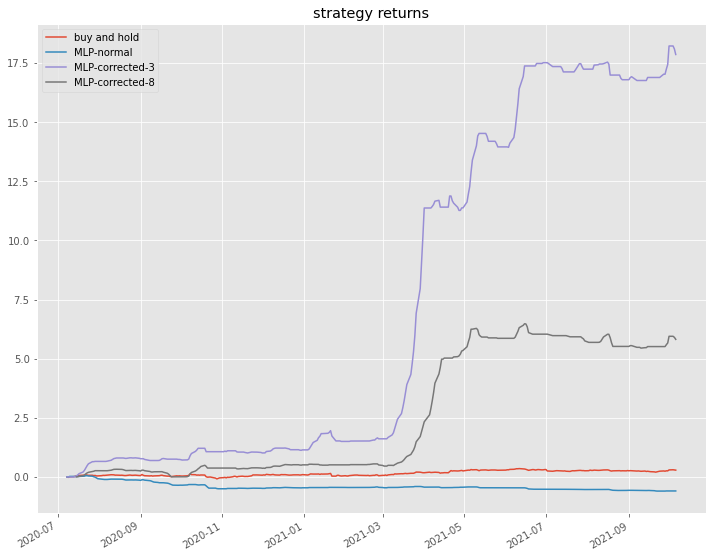

In [ ]:
plt.figure(figsize=(12,10))
mlp_normal['buy_and_hold_cum_ret'].plot(label="buy and hold")
mlp_normal['strategy_return'].plot(label="MLP-normal")
mlp_corrected3['strategy_return'].plot(label="MLP-corrected-3")
mlp_corrected8['strategy_return'].plot(label="MLP-corrected-8")
plt.title("strategy returns")
plt.legend()